In [34]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features.build_features import calcular_kaplan_meier
from src.visualization.visualize import add_dataframes_to_powerpoint

COLOR_PALETTE = [
    "#05a298",
    "#0070bc",
    "#d06b6d",
    "#a8e667",
    "#57832e",
    "#56ebd3",
    "#0a4f4e",
    "#9ecbf4",
]

REEMPLAZO_NOMBRE_TRASPLANTES = {
    "33.51 - TRASPLANTE PULMON.UNILATERAL": "Trasplante Pulmón Unilateral",
    "37.51 - TRASPLANTE CARDIACO": "Trasplante Cardiaco",
    "33.52 - TRASPLANTE PULMON.BILATERAL": "Trasplante Pulmón Bilateral",
}


def find_nearest_index(df, column_name, target_value):
    # Calculate the absolute difference
    df["abs_diff"] = abs(df[column_name] - target_value)

    # Find the index of the row with the minimum absolute difference
    nearest_index = df["abs_diff"].idxmin()

    return nearest_index


sns.set_style("ticks")
sns.set_palette(COLOR_PALETTE)
plt.rcParams["figure.figsize"] = (12, 6)

## Análisis de Sobrevivencia

En este cuadernillo se quiere realizar el análisis de sobrevivencia de pacientes con
trasplante cardiaco en el Instituto Nacional del Tórax. Para este efecto, se utilizará
la base de datos de GRD de pacientes que se hayan realizado un trasplante cardiaco. La base
sigue a pacientes entre 2011 hasta el 16/08/2023 del año 2022.

Las respuestas que se quieren seguir son las siguientes:

- Luego de 2 años del trasplante, ¿Cuál es la probabilidad de que el paciente siga vivo?
- Luego de 10 años del trasplante, ¿Cuál es la probabilidad de que el paciente siga vivo?

Además, se quiere saber cómo es la curva de sobrevivencia para distintos rangos etarios de
pacientes.


In [36]:
# Lee y genera columnas indicadoras
df_2 = pd.read_excel(
    "../data/raw/Trasplantes 2011-2024 240625 Javier.xlsx", sheet_name="Tabla_Tabla2"
).sort_values(by="FECHA TRASPLANTE")
df_2["duracion_anios"] = (df_2["DEF2023.FECHA_DEF"] - df_2["FECHA TRASPLANTE"]).dt.days / 365
df_2["muerto"] = df_2["FALLECIDO_NN"].replace({"Si": True, "No": False})
df_2["anio_intervencion"] = df_2["año intervencion"].astype(str)

In [37]:
RENAME_COLUMNAS = {
    "FECHA TRASPLANTE": "fecha_trasplante",
    "DEF2023.FECHA_DEF": "fecha_muerte",
    "Proced 01 Principal (cod+des)": "tipo_trasplante",
    "Diag 01 Principal (cod+des)": "diagnostico",
    "duracion_anios": "duracion_anios",
    "muerto": "muerto",
    "anio_intervencion": "anio_intervencion"
}

In [38]:
df_sobrevivencia = df_2[RENAME_COLUMNAS.keys()]
df_sobrevivencia = df_sobrevivencia.rename(columns=RENAME_COLUMNAS)
df_sobrevivencia["tipo_trasplante"] = df_sobrevivencia["tipo_trasplante"].replace(
    REEMPLAZO_NOMBRE_TRASPLANTES
)

display(df_sobrevivencia.head(2))

,fecha_trasplante,fecha_muerte,tipo_trasplante,diagnostico,duracion_anios,muerto,anio_intervencion
69,2010-08-02,2011-01-24,Trasplante Pulmón Bilateral,J84.1 - Otras enfermedades pulmonares intersti...,0.479452,True,2010
76,2011-01-07,2012-09-14,Trasplante Pulmón Unilateral,J84.1 - Otras enfermedades pulmonares intersti...,1.687671,True,2011


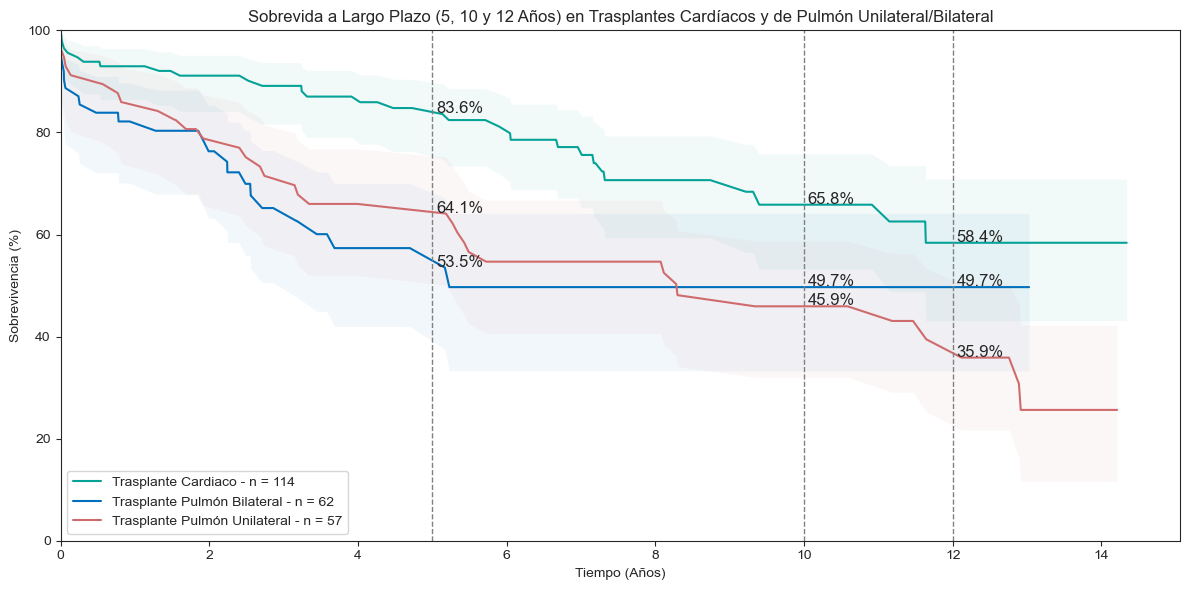

In [71]:
SOBREVIDAS_A_ANALIZAR = [5, 10, 12]
MARGEN_TEXTO_ARRIBA = 0.2
MARGEN_TEXTO_DERECHA = 0.05

fig, axis = plt.subplots(1, 1, figsize=(12, 6))
for tipo_trasplante in sorted(df_sobrevivencia["tipo_trasplante"].unique()):
    df_trasplante = df_sobrevivencia.query("tipo_trasplante == @tipo_trasplante")

    resultado_kaplan = calcular_kaplan_meier(df_trasplante, "duracion_anios", "muerto")

    sns.lineplot(
        resultado_kaplan,
        x="tiempo",
        y="probabilidad_sobrevivencia",
        label=f"{tipo_trasplante} - n = {df_trasplante.shape[0]}",
    )
    plt.fill_between(
        resultado_kaplan["tiempo"],
        resultado_kaplan["limite_confianza_bajo"],
        resultado_kaplan["limite_confianza_alto"],
        alpha=0.05,
    )

    for sobrevida in SOBREVIDAS_A_ANALIZAR:
        duracion_a_sobrevida_anios = find_nearest_index(resultado_kaplan, "tiempo", sobrevida)
        probabilidad_a_sobrevida_anios = resultado_kaplan.iloc[duracion_a_sobrevida_anios, 1]
        # plt.plot(sobrevida, probabilidad_a_sobrevida_anios, color="black", marker="o", markersize=3)
        plt.text(
            sobrevida + MARGEN_TEXTO_DERECHA,
            probabilidad_a_sobrevida_anios + MARGEN_TEXTO_ARRIBA,
            f"{probabilidad_a_sobrevida_anios:.1f}%",
            fontsize=12,
        )


for sobrevida in SOBREVIDAS_A_ANALIZAR:
    plt.axvline(sobrevida, color="gray", linewidth=1, linestyle="--")

plt.ylim(0, 100)
plt.xlim(left=0)
plt.title(
    "Sobrevida a Largo Plazo (5, 10 y 12 Años) en Trasplantes Cardíacos y de Pulmón Unilateral/Bilateral"
)
plt.xlabel("Tiempo (Años)")
plt.ylabel("Sobrevivencia (%)")
plt.legend(loc="lower left")
plt.tight_layout()
fig.savefig("../reports/figures/sobrevida_trasplantes.png", dpi=700)
plt.show()

In [68]:
cuadro_resumen_trasplantes = (
    df_sobrevivencia.groupby(["tipo_trasplante"])["anio_intervencion"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

In [41]:
add_dataframes_to_powerpoint(
    [cuadro_resumen_trasplantes],
    "../reports/presentacion.pptx",
    font_size=11,
    cell_width=14,
    cell_height=0.5,
    font_family="Open Sans",
    max_cell_characters=100,
)